### Exploration of Results

#### Imports

In [36]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Summary of Original Population

#### Reading in the full text file

This is the LogP dataset appended to the Zinc dataset, so that no key errors come when generating compounds

In [37]:
base_fp = './FNLGMD/examples'
tab = pd.read_table(os.path.join(base_fp, 'zinc_smiles_copy.txt'), header=None)
tab.columns = ['smiles']
tab.head()

,smiles
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...


#### Scoring the full dataset

Below is the same score function that can be found in the framework, modified slightly to produced the desired outputs.

In [38]:
from FNLGMD.source.scorers.SAScore import sascorer
from FNLGMD.source.scorers.base_scorer import Scorer
from rdkit.Chem import MolFromSmiles, MolToSmiles, Descriptors, rdmolops
import networkx as nx

def score(population):

    smiles = population['smiles']
    smiles_rdkit = []
    for s in smiles:
        mol = MolFromSmiles(s)
        smi = MolToSmiles(mol,isomericSmiles=False)
        smiles_rdkit.append(smi)

    logP_values = []
    for i in range(len(smiles_rdkit)):
        logP_values.append(Descriptors.MolLogP(MolFromSmiles(smiles_rdkit[ i ])))

    SA_scores = []
    for i in range(len(smiles_rdkit)):
        SA_scores.append(-sascorer.calculateScore(MolFromSmiles(smiles_rdkit[ i ])))

    cycle_scores = []

    for i in range(len(smiles_rdkit)):
        cycle_list = nx.cycle_basis(nx.Graph(rdmolops.GetAdjacencyMatrix(MolFromSmiles(smiles_rdkit[ i ]))))

        if len(cycle_list) == 0:
            cycle_length = 0
        else:
            cycle_length = max([ len(j) for j in cycle_list ])
        if cycle_length <= 6:
            cycle_length = 0
        else:
            cycle_length = cycle_length - 6
        cycle_scores.append(-cycle_length)

    SA_scores_normalized = (np.array(SA_scores) - np.mean(SA_scores)) / np.std(SA_scores)
    logP_values_normalized = (np.array(logP_values) - np.mean(logP_values)) / np.std(logP_values)
    cycle_scores_normalized = (np.array(cycle_scores) - np.mean(cycle_scores)) / np.std(cycle_scores)

    SA_scores_normalized[np.isnan(SA_scores_normalized)] = 0.0
    logP_values_normalized[np.isnan(logP_values_normalized)] = 0.0
    cycle_scores_normalized[np.isnan(cycle_scores_normalized)] = 0.0

    targets = SA_scores_normalized + logP_values_normalized + cycle_scores_normalized
    population['fitness'] = targets

    return logP_values, SA_scores, cycle_scores, targets

In [12]:
# Only need to run once, takes a long time
# logP_values, SA_scores, cycle_scores, targets = score(tab)

In [17]:
# tab['fitness'] = targets
# tab['logP'] = logP_values
# tab['SA_scores'] = SA_scores
# tab['cycle_scores'] = cycle_scores

# # tab1 = pd.read_csv(os.path.join(base_fp, 'lipo.csv'))
# # tab2 = pd.read_csv(os.path.join(base_fp, 'bal.csv'))
# # tab3 = pd.read_csv(os.path.join(base_fp, 'hydro.csv'))

# # TAB = pd.concat([tab1, tab2, tab3])

# tab.to_csv('./results/all_scores.csv')

In [39]:
# Normalize the scores
tab = pd.read_csv('./results/all_scores.csv')
tab.head()

,Unnamed: 0,smiles,fitness,logP,SA_scores,cycle_scores
0,0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,3.128082,5.05060,-2.084095,0
1,1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,0.186324,3.11370,-3.432004,0
2,2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,2.611618,4.96778,-2.470633,0
3,3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,-1.695819,4.00022,-2.822753,-1
4,4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,-0.186917,3.60956,-4.035182,0


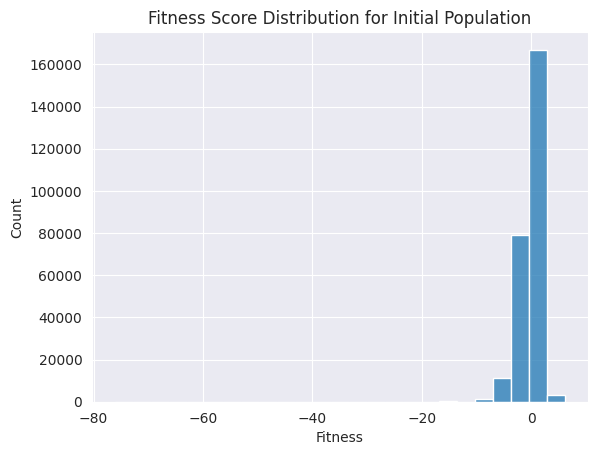

In [40]:
# Original Histogram of fitness scores 
import warnings
warnings.filterwarnings("ignore")

sns.set_style(style='darkgrid')
sns.histplot(tab['fitness'], bins=25)
plt.xlabel('Fitness')
plt.title('Fitness Score Distribution for Initial Population')
plt.savefig('./results/figures/initial_hist.png')
plt.show()

In [41]:
def normalize_col(dat, col):
    return (dat[col] - dat[col].mean()) / dat[col].std(ddof=1)

In [42]:
normalized_logP = normalize_col(tab, 'logP')

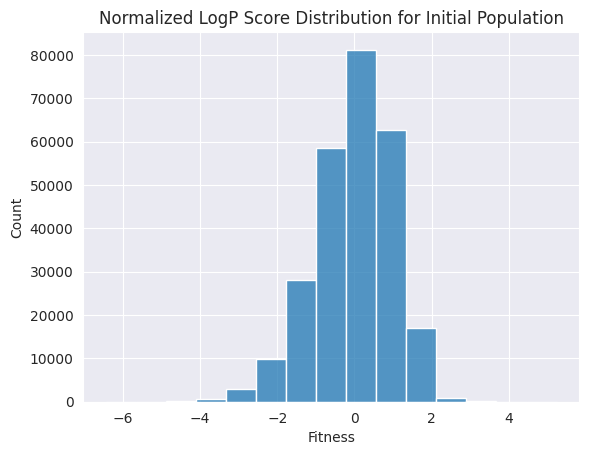

In [43]:
sns.histplot(normalized_logP, bins=15)
plt.xlabel('Fitness')
plt.title('Normalized LogP Score Distribution for Initial Population')
plt.savefig('./results/figures/hist1.png')
plt.show()

In [44]:
normalized_SA = normalize_col(tab, 'SA_scores')

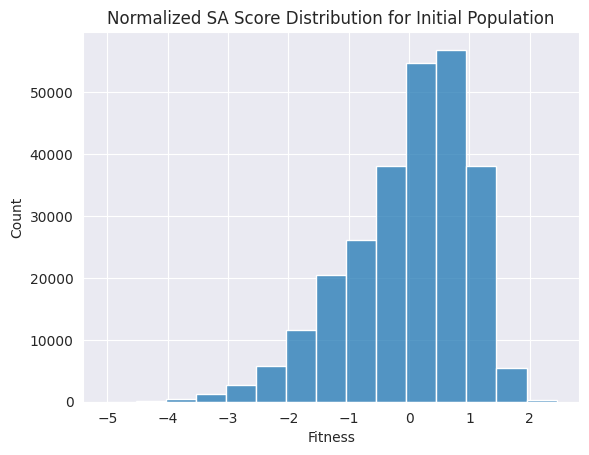

In [45]:
sns.histplot(normalized_SA, bins=15)
plt.xlabel('Fitness')
plt.title('Normalized SA Score Distribution for Initial Population')
plt.savefig('./results/figures/hist2.png')
plt.show()

In [125]:
normalized_cycle = normalize_col(tab, 'cycle_scores')

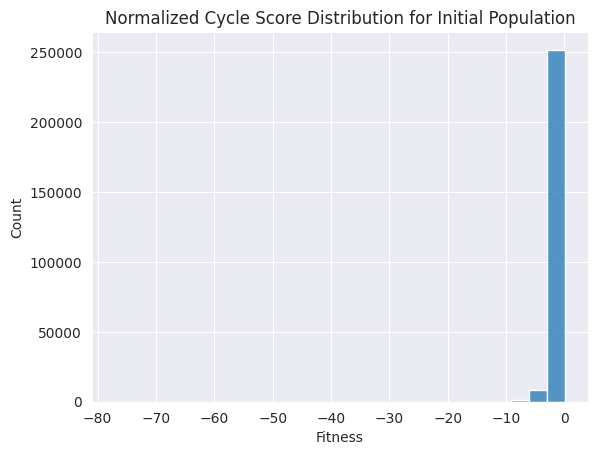

In [136]:
sns.histplot(normalized_cycle, bins=25)
plt.xlabel('Fitness')
plt.title('Normalized Cycle Score Distribution for Initial Population')
#plt.savefig('./results/figures/hist2.png')
plt.show()

In [127]:
min(tab['cycle_scores'])

-24

In [47]:
pd.Series(tab['fitness']).describe().to_frame()

,fitness
count,2.621650e+05
mean,7.036722e-16
std,2.037665e+00
min,-7.615286e+01
25%,-1.053419e+00
50%,4.079961e-01
75%,1.402782e+00
max,6.249698e+00


In [48]:
fp = 'FNLGMD/examples/autogrow_data2.csv'
auto_tab = pd.read_csv(fp)
auto_tab.head()

,smiles,parent1_id,reaction_id,zinc_id,source,generation,parent2_id,compound_id,fitness
0,CCCC(C)(C)Oc1ccc(OC)c(S(=O)(=O)N[C@H](c2ccccc2...,4.0,19.0,ZINC000001648167,mutation,"[1, 2]",NaN,50.0,1.607781
1,COC[C@@H](C)OC(=O)c1ccccc1-c1nc2ccc(OC)cc2cc1C...,36.0,89.0,ZINC001606798926,mutation,"[1, 2, 3]",NaN,51.0,2.436105
2,COCc1cccc(N(C(=S)NC2=CCS(=O)(=O)C2)[C@@H](C)C(...,5.0,94.0,ZINC000002454917,mutation,[1],NaN,52.0,-1.403251
3,Cc1ccc(C2OC2CC(=O)NCc2ccc(Cn3cncn3)cc2)cc1,46.0,3.0,NaN,mutation,[1],NaN,53.0,-1.011008
4,[N-]=[N+]=Nc1cc(-c2cccc(C(=O)NC3CC3)c2)ccc1C=O,39.0,6.0,NaN,mutation,"[1, 2]",NaN,54.0,1.049021


In [98]:
l1, s1, c1, t1 = [], [], [], []
for i in range(len(auto_tab)):
    try:
        a1, a2, a3, a4 = score(auto_tab.iloc[i+1].to_frame().T)
        l1.append(a1)
        s1.append(a2)
        c1.append(a3)
        t1.append(a4)
        
    except:
        l1.append([np.NaN])
        s1.append([np.NaN])
        c1.append([np.NaN])
        t1.append([np.NaN])
        
        continue

[13:52:27] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 15


In [50]:
log_ser = pd.Series(sum(l1, []))

### Analyzing Results from Generated Populations

#### Reading in the data
All csvs are labeled based on the parameters of mate and mutate probability used to generate the population

In [52]:
res_fp = './results'
gen_files = [f for f in os.listdir(res_fp) if f.startswith('mate_07')]
dats = [pd.read_csv(os.path.join(res_fp, f)) for f in gen_files]
#fits = [(d['fitness'] - d['fitness'].mean())/d['fitness'].std(ddof=1) for d in dats]
fits = [d['fitness'] for d in dats]

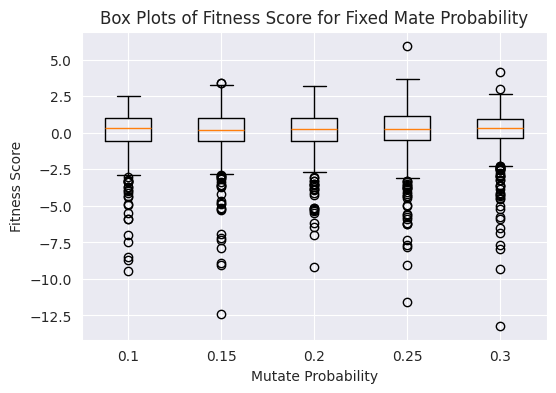

In [53]:
import matplotlib.pyplot as plt
import numpy as np

data_to_plot = fits

# Creating box plots
plt.figure(figsize=(6, 4))
plt.boxplot(data_to_plot)

# Setting the labels and title, if necessary
plt.title('Box Plots of Fitness Score for Fixed Mate Probability')
plt.xlabel('Mutate Probability')
plt.xticks(ticks = [1, 2, 3, 4, 5], labels=[0.1, 0.15, 0.2, 0.25, 0.3])
plt.ylabel('Fitness Score')
plt.savefig('./results/figures/box1.png')

# Showing the plot
plt.show()

In [54]:
gen_files = [f for f in os.listdir(res_fp) if 'mutate_01_' in f]
dats = [pd.read_csv(os.path.join(res_fp, f)) for f in gen_files]
fits = [d['fitness'] for d in dats]

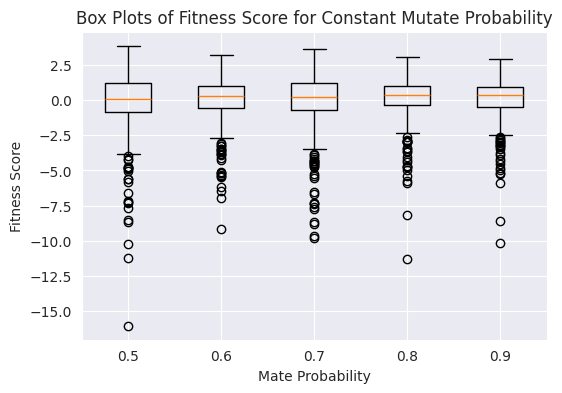

In [55]:
data_to_plot = fits

# Creating box plots
plt.figure(figsize=(6, 4))
plt.boxplot(data_to_plot)

# Setting the labels and title, if necessary
plt.title('Box Plots of Fitness Score for Constant Mutate Probability')
plt.xlabel('Mate Probability')
plt.xticks(ticks = [1, 2, 3, 4, 5], labels=[0.5, 0.6, 0.7, 0.8, 0.9])
plt.ylabel('Fitness Score')
plt.savefig('./results/figures/hist2.png')

# Showing the plot
plt.show()

In [57]:
# Writing the different taxonomies (ahahahaha see what i did there) to a txt file
# tab['logP'] = logP_values
# tab['SA'] = SA_scores
# tab['cycle'] = cycle_scores
# tab.head()

In [58]:
lipo  = tab.loc[tab['logP'] >= 3, ]
hydro = tab.loc[tab['logP'] <= 0, ]
bal   = tab.loc[(tab['logP'] > 0) & (tab['logP'] < 3), ]

In [142]:
# with open(os.path.join(base_fp, 'lipo.txt'), 'w') as file:
#     for entry in lipo['smiles']:
#         file.write(str(entry) + '\n')
        
# with open(os.path.join(base_fp, 'hydro.txt'), 'w') as file:
#     for entry in hydro['smiles']:
#         file.write(str(entry) + '\n')
        
# with open(os.path.join(base_fp, 'bal.txt'), 'w') as file:
#     for entry in bal['smiles']:
#         file.write(str(entry) + '\n')

In [59]:
gen_files = ['mate_07_mutate_01_mutatestd_1.csv', 'balanced_results.csv', 
             'lipo_results.csv', 'hydro_results.csv']
dats = [pd.read_csv(os.path.join(res_fp, f)) for f in gen_files]
fits = [d['fitness'] for d in dats]

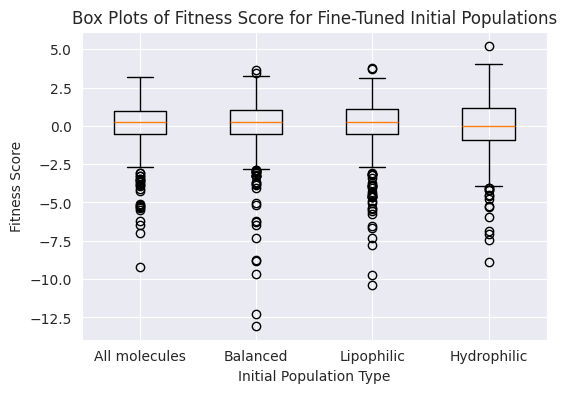

In [60]:
data_to_plot = fits

# Creating box plots
plt.figure(figsize=(6, 4))
plt.boxplot(data_to_plot)

# Setting the labels and title, if necessary
plt.title('Box Plots of Fitness Score for Fine-Tuned Initial Populations')
plt.xlabel('Initial Population Type')
plt.xticks(ticks = [1, 2, 3, 4], labels=['All molecules', 'Balanced', 'Lipophilic', 'Hydrophilic'])
plt.ylabel('Fitness Score')
plt.savefig('./results/figures/box3.png')

# Showing the plot
plt.show()

#### For the heatmap

In [61]:
res_fp = './results'
gen_files = [f for f in os.listdir(res_fp) if f.startswith('mate')]

In [62]:
arr = np.array([])
for f in sorted(gen_files):
    dat = pd.read_csv(os.path.join(res_fp, f))
    mean = np.mean(dat['fitness'])
    arr = np.append(arr, mean)

In [63]:
heat = arr.reshape(5, 5)

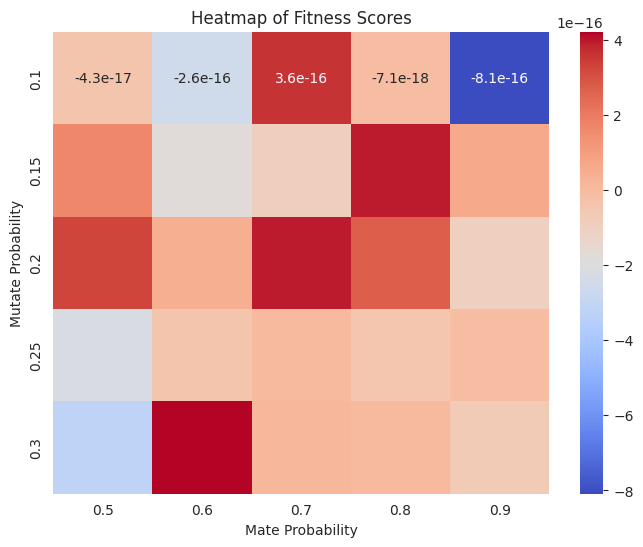

In [64]:
data = np.random.rand(10, 10)  # An example 10x10 array

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heat, cmap="coolwarm", annot=True)
plt.title('Heatmap of Fitness Scores')
plt.xlabel('Mate Probability')
plt.ylabel('Mutate Probability')
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=[0.5, 0.6, 0.7, 0.8, 0.9])
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=[0.1, 0.15, 0.2, 0.25, 0.3])
plt.savefig('./results/figures/heat1.png')
plt.show()

In [75]:
res_fp = './results'

gen_files = ['mate_07_mutate_01_mutatestd_1.csv', 'balanced_results.csv', 
             'lipo_results.csv', 'hydro_results.csv']
dats = [pd.read_csv(os.path.join(res_fp, f)) for f in gen_files]

for d in dats:
    d['logP'], d['SA'], d['cycle'], d['fitnes'] = score(d)

In [76]:
def filter_fitness(x):
    if x >= 0 and x <= 3:
        return 'balanced'
    if x < 0:
        return 'lipophilic'
    if x > 3:
        return 'hydrophilic'

In [77]:
for d in dats:
    d['source'] = d['logP'].apply(filter_fitness)

In [78]:
counts = dats[0].groupby('source').count()['logP'] 
counts = (counts/counts.sum()).to_frame()
counts

,logP
source,
balanced,0.451327
hydrophilic,0.539823
lipophilic,0.008850


In [79]:
counts2 = dats[1].groupby('source').count()['logP'] 
counts2 = (counts2/counts2.sum()).to_frame()
counts2

,logP
source,
balanced,0.672566
hydrophilic,0.305310
lipophilic,0.022124


In [80]:
counts3 = dats[2].groupby('source').count()['logP'] 
counts3 = (counts3/counts3.sum()).to_frame()
counts3

,logP
source,
balanced,0.533186
hydrophilic,0.132743
lipophilic,0.334071


In [81]:
counts4 = dats[3].groupby('source').count()['logP'] 
counts4 = (counts4/counts4.sum()).to_frame()
counts4

,logP
source,
balanced,0.190265
hydrophilic,0.798673
lipophilic,0.011062


In [82]:
stacked = pd.concat([counts, counts2, counts3, counts4], axis=1)
stacked

,logP,logP,logP,logP
source,,,,
balanced,0.451327,0.672566,0.533186,0.190265
hydrophilic,0.539823,0.305310,0.132743,0.798673
lipophilic,0.008850,0.022124,0.334071,0.011062


In [83]:
stacked.iloc[0]

logP    0.451327
logP    0.672566
logP    0.533186
logP    0.190265
Name: balanced, dtype: float64

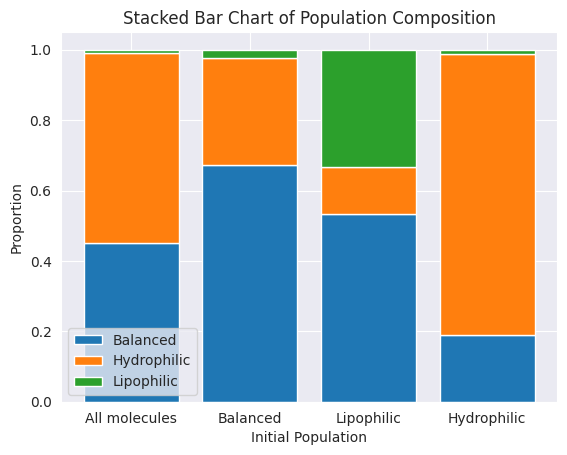

In [85]:

categories = ['All molecules', 'Balanced', 'Lipophilic', 'Hydrophilic']
values1 = stacked.iloc[0].values
values2 = stacked.iloc[1].values
values3 = stacked.iloc[2].values
# categories = ['A', 'B', 'C', 'D', 'E']
# values1 = [5, 8, 6, 4, 7]
# values2 = [3, 6, 2, 6, 4]
# values3 = [4, 7, 5, 7, 8]

x = np.arange(len(categories))

# Plotting stacked bar chart
plt.bar(x, values1, label='Balanced')
plt.bar(x, values2, bottom=values1, label='Hydrophilic')
# To stack values3, we need to add both values1 and values2
values1_plus_values2 = np.add(values1, values2).tolist()
plt.bar(x, values3, bottom=values1_plus_values2, label='Lipophilic')

plt.xlabel('Initial Population')
plt.ylabel('Proportion')
plt.title('Stacked Bar Chart of Population Composition')
plt.xticks(x, categories)
plt.legend()

plt.show()

In [115]:
res_fp = './results'

gen_files = ['autogrow_all_test.csv', 'results_autobal.csv', 
             'results_autolipo.csv', 'results_autohydro.csv']
dats = [pd.read_csv(os.path.join(res_fp, f)) for f in gen_files]

for d in dats:
    l1, s1, c1, t1 = [], [], [], []
    for i in range(len(d)):
        try:
            a1, a2, a3, a4 = score(d.iloc[i+1].to_frame().T)
            l1.append(a1)
            s1.append(a2)
            c1.append(a3)
            t1.append(a4)

        except:
            l1.append([np.NaN])
            s1.append([np.NaN])
            c1.append([np.NaN])
            t1.append([np.NaN])

            continue
            
    d['logP'], d['SA'], d['cycle']= sum(l1, []), sum(s1, []), sum(c1, [])

[14:19:45] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20


In [116]:
for d in dats:
    d['source'] = d['logP'].apply(filter_fitness)

In [117]:
counts = dats[0].groupby('source').count()['logP'] 
counts = (counts/counts.sum()).to_frame()
counts

,logP
source,
balanced,0.048193
hydrophilic,0.951807


In [118]:
counts2 = dats[1].groupby('source').count()['logP'] 
counts2 = (counts2/counts2.sum()).to_frame()
counts2

,logP
source,
balanced,0.138554
hydrophilic,0.861446


In [119]:
counts3 = dats[2].groupby('source').count()['logP'] 
counts3 = (counts3/counts3.sum()).to_frame()
counts3

,logP
source,
balanced,0.016064
hydrophilic,0.983936


In [120]:
counts4 = dats[3].groupby('source').count()['logP'] 
counts4 = (counts4/counts4.sum()).to_frame()
counts4

,logP
source,
balanced,0.457831
hydrophilic,0.341365
lipophilic,0.200803


In [123]:
stacked = pd.concat([counts, counts2, counts4, counts3], axis=1)
stacked

,logP,logP,logP,logP
source,,,,
balanced,0.048193,0.138554,0.457831,0.016064
hydrophilic,0.951807,0.861446,0.341365,0.983936
lipophilic,NaN,NaN,0.200803,NaN


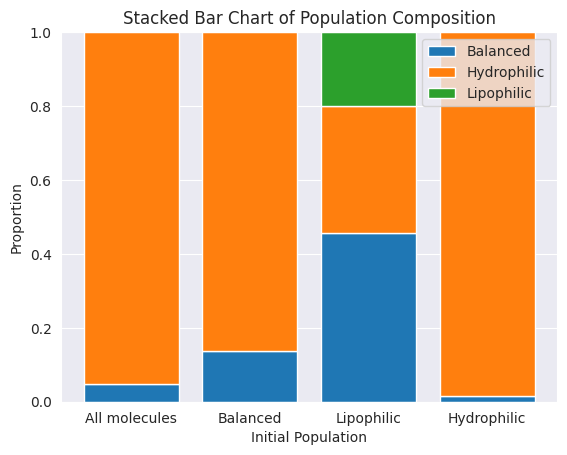

In [124]:
categories = ['All molecules', 'Balanced', 'Lipophilic', 'Hydrophilic']
values1 = stacked.iloc[0].values
values2 = stacked.iloc[1].values
values3 = stacked.iloc[2].values
# categories = ['A', 'B', 'C', 'D', 'E']
# values1 = [5, 8, 6, 4, 7]
# values2 = [3, 6, 2, 6, 4]
# values3 = [4, 7, 5, 7, 8]

x = np.arange(len(categories))

# Plotting stacked bar chart
plt.bar(x, values1, label='Balanced')
plt.bar(x, values2, bottom=values1, label='Hydrophilic')
# To stack values3, we need to add both values1 and values2
values1_plus_values2 = np.add(values1, values2).tolist()
plt.bar(x, values3, bottom=values1_plus_values2, label='Lipophilic')

plt.xlabel('Initial Population')
plt.ylabel('Proportion')
plt.title('Stacked Bar Chart of Population Composition')
plt.xticks(x, categories)
plt.legend()

plt.show()